In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

from sda.mcs import *
from sda.score import *
from sda.utils import *

from utils import *

def coarsen(x, r):
    *batch, H, W = x.shape

    x = x.reshape(*batch, H // r, r, W // r, r)
    x = x.mean(dim=(-1, -3))

    return x

## Test set

In [2]:
testset = RandomCropDataset(PATH / 'data/coarse/test.h5')

c = testset.grid.cuda()

## Score network

In [3]:
# score = load_score(PATH / 'runs/ethereal-dawn-26_u79s6bgt/state.pth')  # k=4, channels=16, kernel_size=3
score = load_score(PATH / 'runs/lively-leaf-29_b070ikso/state.pth')  # k=4, channels=16, kernel_size=5

_ = score.requires_grad_(False)

## Uniform subsampling

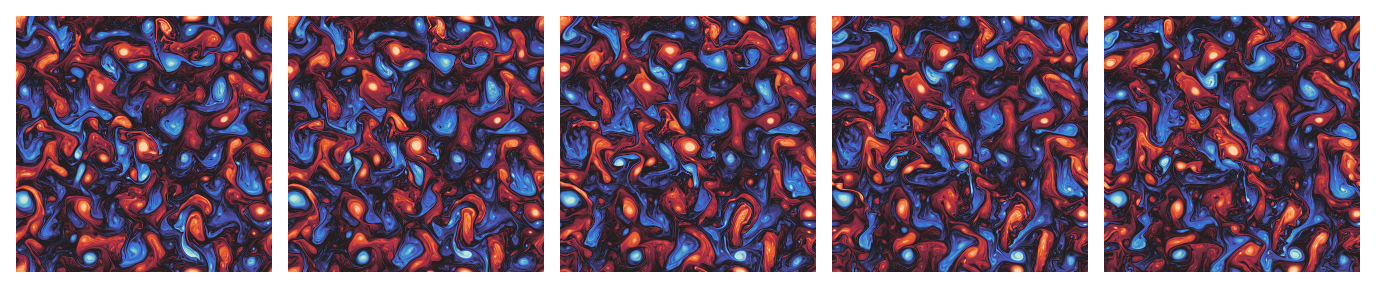

In [4]:
x_star, _ = testset[0]

draw(x_star[2::6, 0]).save('x_star_uniform.png')
draw(x_star[2::6, 0])

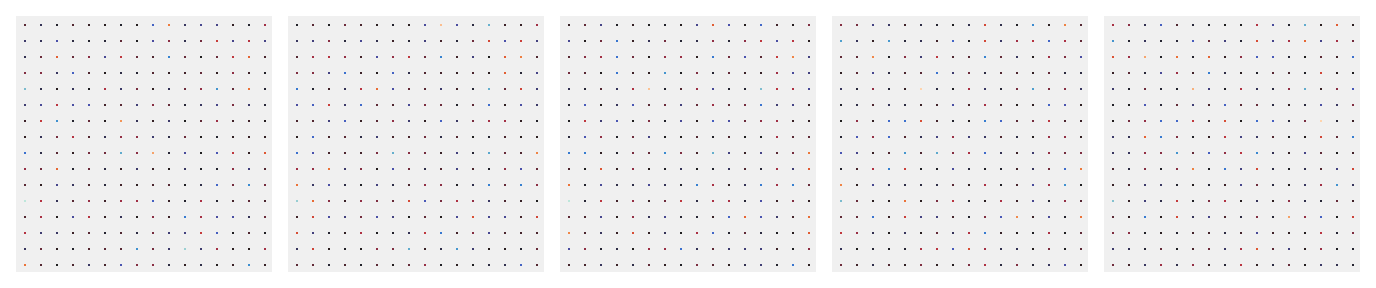

In [5]:
def A(x):
    return coarsen(x, 2)[..., (1, 2, 4, 5), 4::8, 4::8]

y_star = torch.normal(A(x_star), 1e-2)

q = coarsen(x_star[2::6, 0], 2)

mask = np.zeros((5, 128, 128), dtype=bool)
mask[:, 4::8, 4::8] = True

draw(q, mask, pad=8, zoom=2).save('y_star_uniform.png')
draw(q, mask, pad=8, zoom=2)

100%|█████████████████████████████████████████████████| 256/256 [18:08<00:00,  4.25s/it]


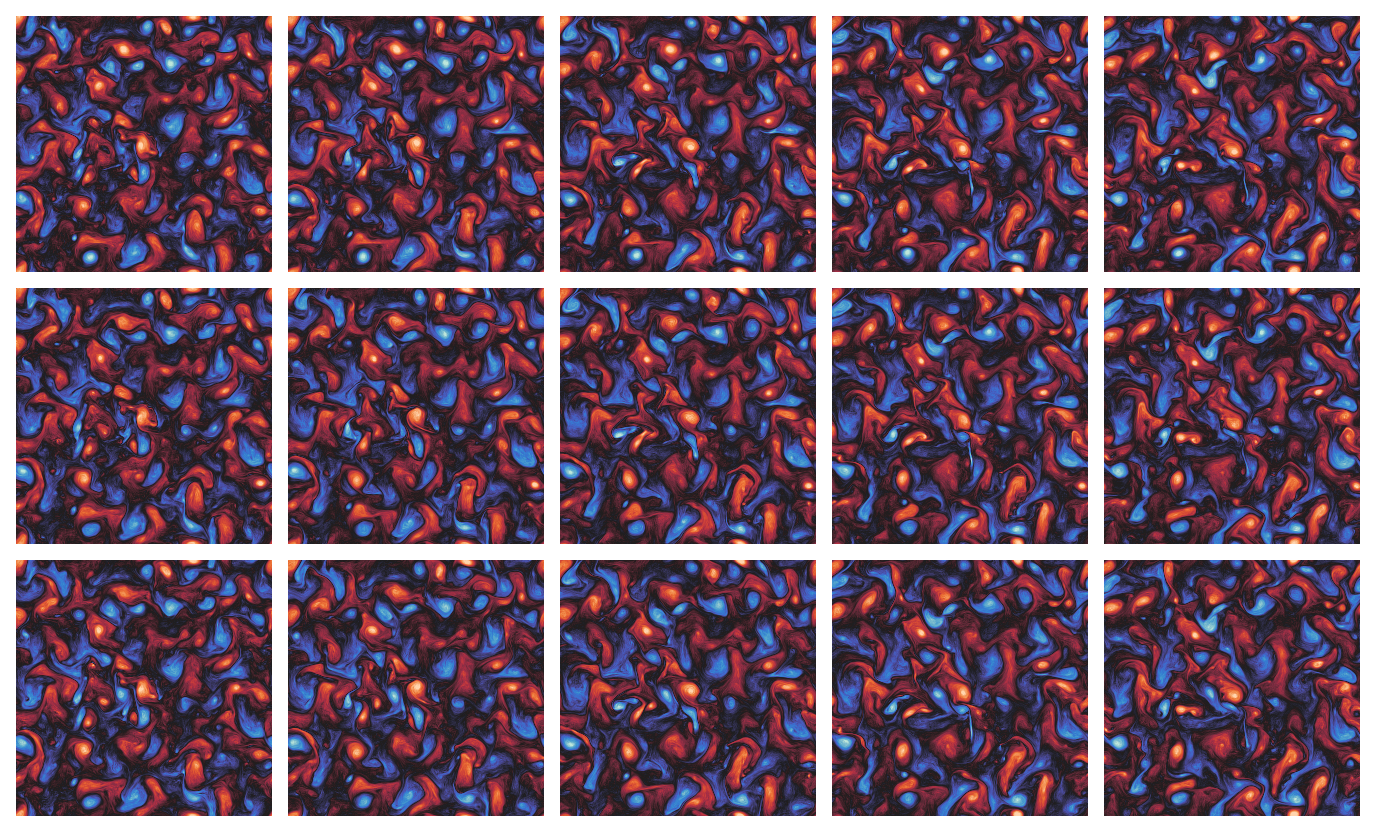

In [6]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=1e-2,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample((3,), c=c, steps=256, corrections=1, tau=0.5).cpu()

draw(x[:, 2::6, 0]).save('x_sda_uniform.png')
draw(x[:, 2::6, 0])

In [7]:
save_gif(x_star[:, 0], 'x_star_uniform.gif')
save_gif(x[0, :, 0], 'x_sda_uniform.gif')

## Random subsampling

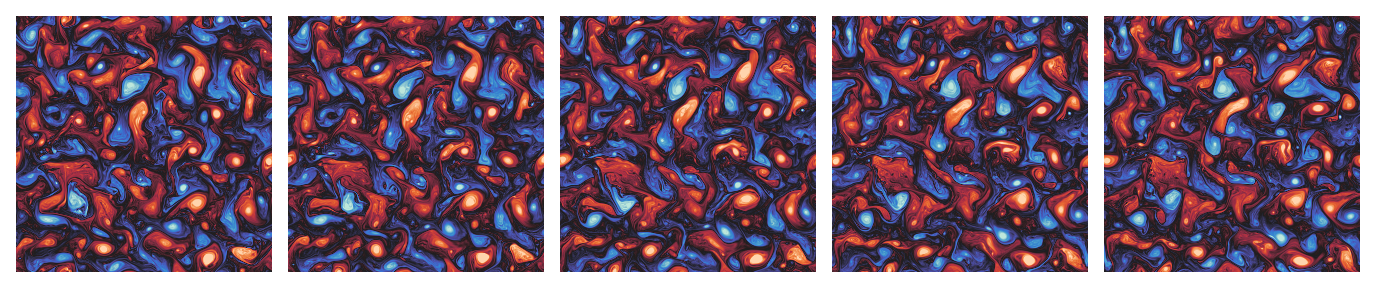

In [8]:
x_star, _ = testset[3]

draw(x_star[2::6, 0]).save('x_star_random.png')
draw(x_star[2::6, 0])

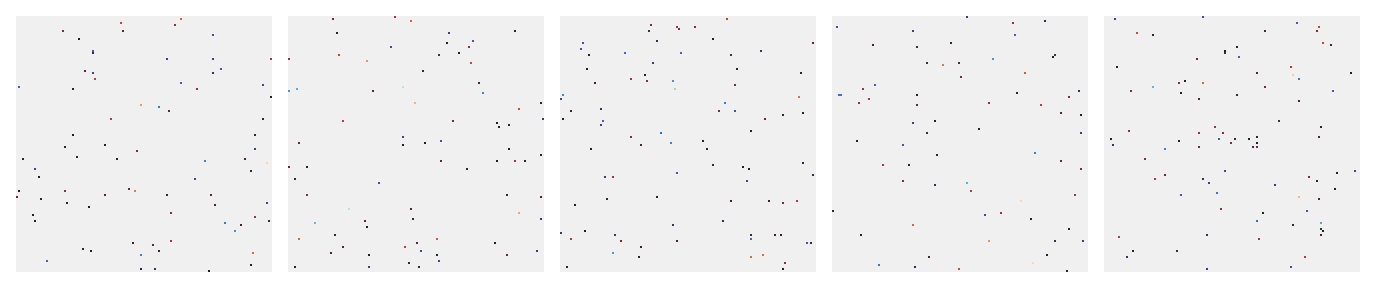

In [9]:
mask = torch.rand(32, 1, 128, 128) < 0.005

def A(x):
    return coarsen(x, 2)[..., (1, 2, 4, 5), :, :] * mask.to(x.device)

y_star = torch.normal(A(x_star), 1e-1)

q = coarsen(x_star[2::6, 0], 2)

draw(q, mask[2::6, 0].numpy(), pad=8, zoom=2).save('y_star_random.png')
draw(q, mask[2::6, 0].numpy(), pad=8, zoom=2)

100%|█████████████████████████████████████████████████| 256/256 [18:08<00:00,  4.25s/it]


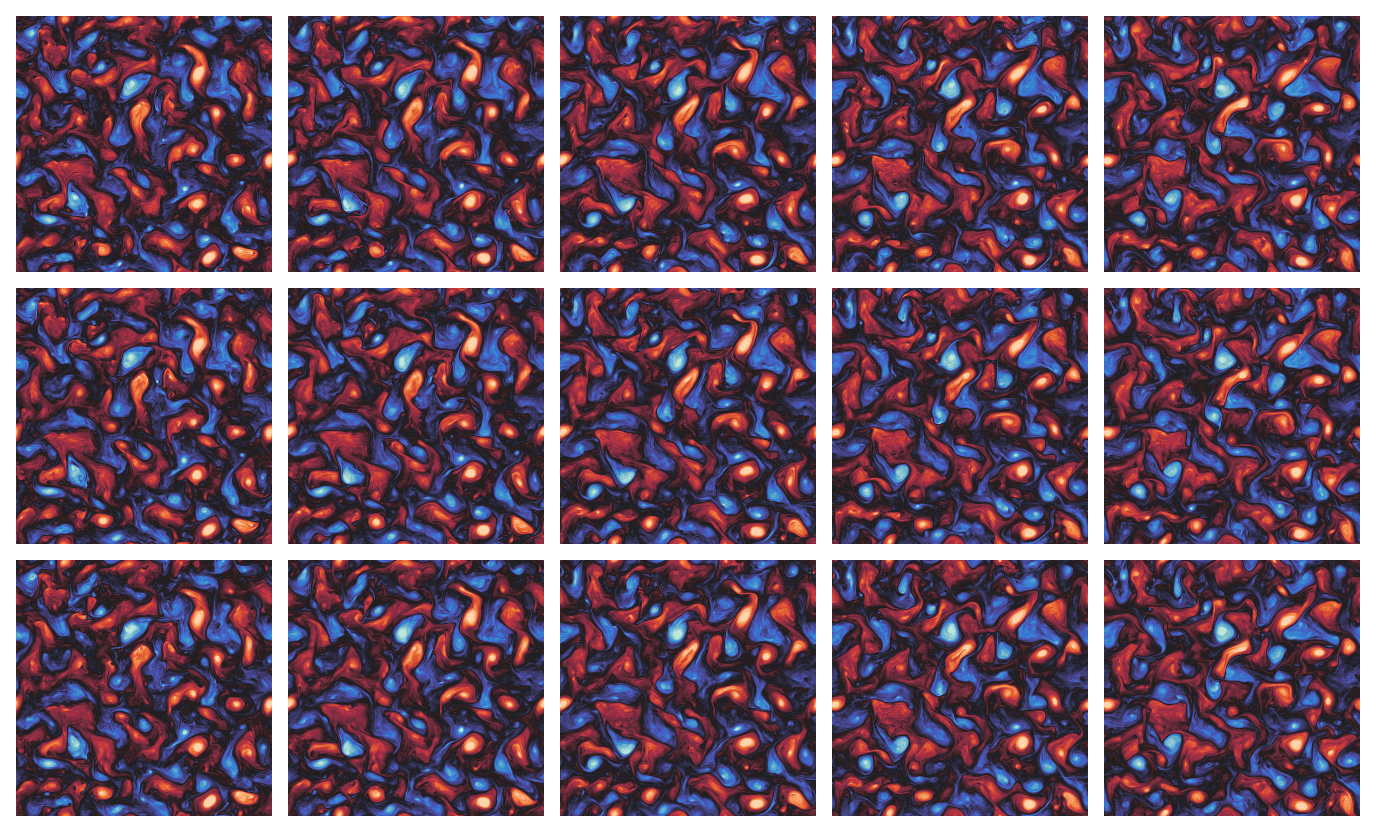

In [10]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=1e-2,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample((3,), c=c, steps=256, corrections=1, tau=0.5).cpu()

draw(x[:, 2::6, 0]).save('x_sda_random.png')
draw(x[:, 2::6, 0])

In [11]:
save_gif(x_star[:, 0], 'x_star_random.gif')
save_gif(x[0, :, 0], 'x_sda_random.gif')